In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc
from jdgsim.option_classes import SimulationConfig, SimulationParams
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration

# 2 body problem

In [12]:
# Define the 
config = SimulationConfig(N_particles=2, return_snapshots=True, num_snapshots=10, num_timesteps=100000, external_accelerations=(), softening=1e-10) #default values

params = SimulationParams(t_end = 100, G=1) #default values
# pos, vel, mass = ic_two_body(mass2, mass1, rp=5, e=1, config=config, params=params)
pos = jnp.array([[0.0, 0.0, 0.0], [5.0, 0.0, 0.0]])
vel = jnp.array([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]) 
mass = jnp.array([1, 1])
initial_state = construct_initial_state(pos, vel)

def direct_acc_new(state, mass, config, params, return_potential=False):
    
    x = state[:, 0, 0]
    y = state[:, 0, 1]
    z = state[:, 0, 2]

    delta_x = x.reshape(config.N_particles, 1) - x
    delta_y = y.reshape(config.N_particles, 1) - y
    delta_z = z.reshape(config.N_particles, 1) - z

    r_ij = jnp.stack([delta_x, delta_y, delta_z], axis=0)
    r_mag = jnp.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
    
    # return r_ij, r_mag
    acc_mag = params.G * mass / (r_mag + config.softening)**2
    if return_potential:
        return  jnp.sum(r_ij*(acc_mag/(r_mag+config.softening)), axis=1).T, jnp.sum(- acc_mag*r_mag, axis=1)
    else:   
        return  jnp.sum((acc_mag/(r_mag+config.softening)) * r_ij, axis=1).T

In [13]:
final_state = direct_acc_new(initial_state, mass, config, params, return_potential=True)
print(final_state[0].shape)

(2, 3)


In [14]:
final_state[1]

Array([-0.2, -0.2], dtype=float64)

In [5]:
final_state = direct_acc(initial_state, mass, config, params, return_potential=True)

SimulationConfig(N_particles=2, dimensions=3, return_snapshots=True, num_snapshots=10, fixed_timestep=True, num_timesteps=1000, softening=1e-10, integrator=0, acceleration_scheme=0, external_accelerations=())
SimulationParams(G=1, t_end=10, Plummer_a=7)


Text(0.5, 0, 'Z')

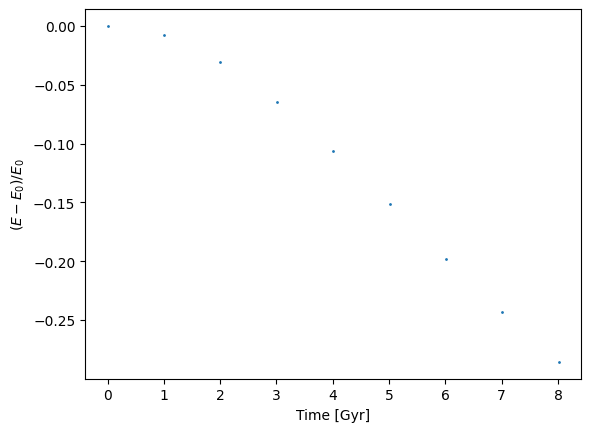

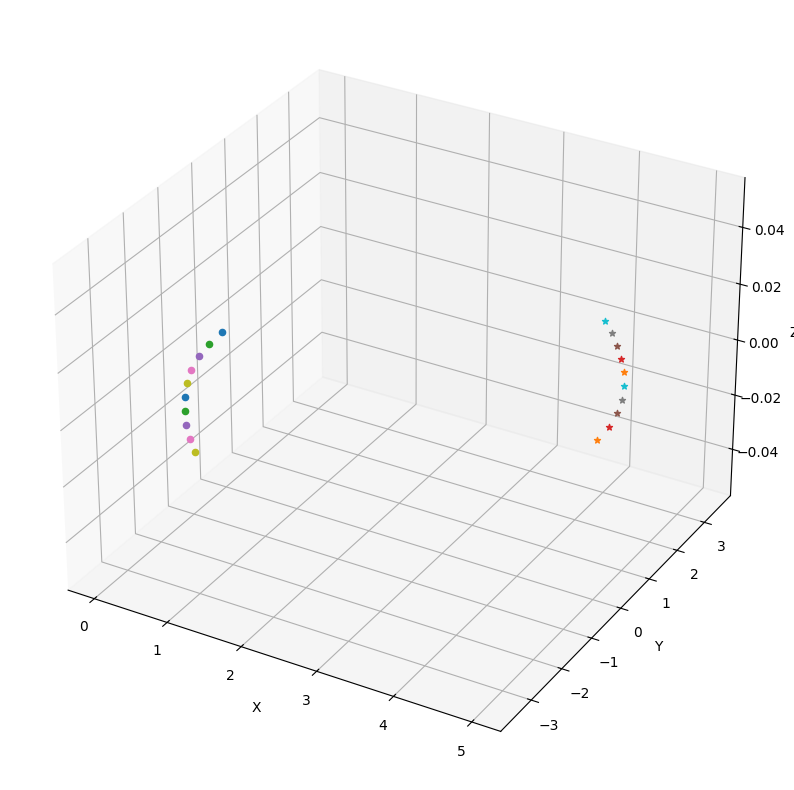

In [22]:

# Define the 
config = SimulationConfig(N_particles=2, return_snapshots=True, num_snapshots=10, num_timesteps=1000, external_accelerations=(), softening=1e-10) #default values

params = SimulationParams(t_end = 10, G=1) #default values

print(config)
print(params)

mass1 = 1
mass2 = 1

pos, vel, mass = ic_two_body(mass2, mass1, rp=5, e=1, config=config, params=params)
# pos = jnp.array([[0.0, 0.0, 0.0], [5.0, 0.0, 0.0]])
# vel = jnp.array([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]) 
mass = jnp.array([mass1, mass2])
initial_state = construct_initial_state(pos, vel)

snapshots= time_integration(initial_state, mass, config, params)
# check the energy conservation, remove the last snapshot:
Delta_E = ((snapshots.total_energy - snapshots.total_energy[0])/snapshots.total_energy[0])[:-1]
plt.scatter(snapshots.times[:-1], Delta_E, s=1)
plt.xlabel('Time [Gyr]')
plt.ylabel(r'$(E - E_0)/E_0$')
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(snapshots.states), 1):
    ax.scatter(snapshots.states[i, 0, 0, 0], snapshots.states[i, 0, 0, 1], snapshots.states[i, 0, 0, 2], label=f"t={snapshots.times[i]:.2f} small body")
    ax.scatter(snapshots.states[i, 1, 0, 0], snapshots.states[i, 1, 0, 1], snapshots.states[i, 1, 0, 2], marker='*',)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.set_xlim(-20, 20)
# ax.set_ylim(-20, 20)
# ax.set_zlim(-20, 20)
# plt.legend()



In [12]:
from jdgsim.utils import E_tot

print(E_tot(snapshots, mass, config, params))
print(E_tot(initial_state, mass, config, params))

-0.024744622310425485
-0.19999999998400006


# Plummer Sphere

In [15]:

# Define the 
config = SimulationConfig(N_particles=1_000, return_snapshots=True, num_snapshots=1000, num_timesteps=100_000, external_accelerations=()) #default values

params = SimulationParams(t_end = 10, Plummer_a = 2) #default values

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=True, num_snapshots=1000, fixed_timestep=True, num_timesteps=100000, softening=1e-10, integrator=0, acceleration_scheme=0, external_accelerations=())
SimulationParams(G=4.498e-06, t_end=10, Plummer_a=2)


In [16]:
mass = np.ones(config.N_particles) 

#set up the particles in the initial state
positions, velocities = Plummer_sphere(mass=mass, params=params, config=config)
mass = jnp.array(mass)
#move the center to 10 Kpc distance from the center of the galaxy
# position = position + jnp.array([10, 0, 0])


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

# #put the plummer sphere com at 10 Kpc from the center of the galaxy in a circular orbit
# com = center_of_mass(initial_state, mass)
# pos, vel, _ = ic_two_body(params.NFW_params['Mvir'], jnp.sum(mass), rp=10, e=1, config=config, params=params)

# positions = positions + pos[1]
# velocities = velocities + vel[1]


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

/export/home/vgiusepp/jdgsim/jdgsim/initial_condition.py:67: RuntimeWarning: invalid value encountered in power
  isotropic_velocity_mask = np.random.uniform(size=rejection_samples) <= ((0.5 * np.sum(velocity_i**2, axis=1) + potential_i ) / potential_i)**(7/2)


In [17]:
if config.return_snapshots: 
    snapshots = time_integration(initial_state, mass, config, params)
else:
    final_state = time_integration(initial_state, mass, config, params)


/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


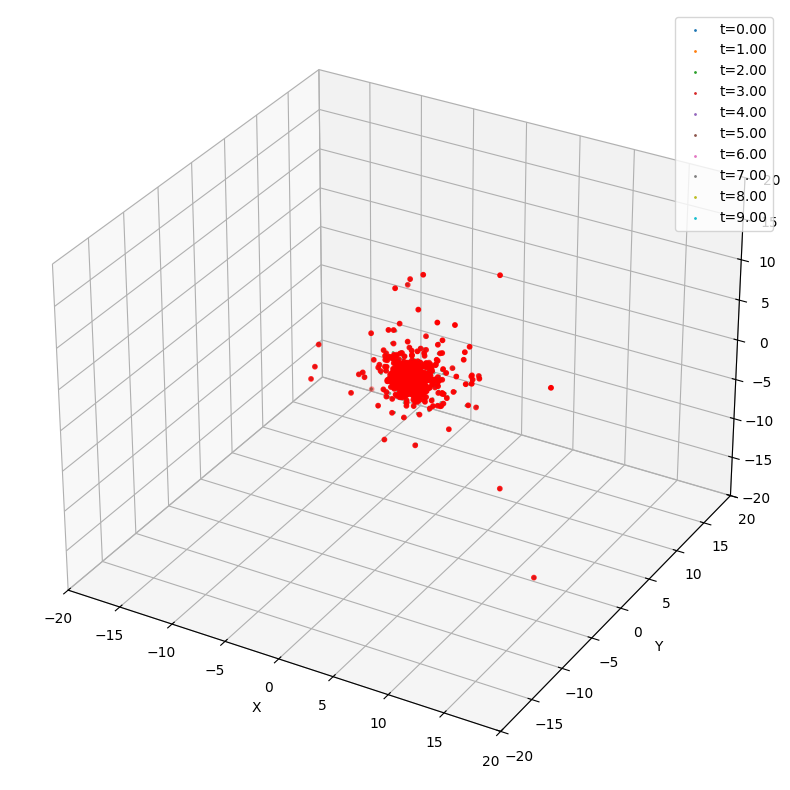

In [18]:
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(snapshots.states), 100):
    ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2] , s=1, label=f"t={snapshots.times[i]:.2f}")
# ax.scatter(final_state[:, 0, 0], final_state[:, 0, 1], final_state[:, 0, 2], alpha=0.1)
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='r', s=10)
ax.scatter(0, 0, 0, c='r', s=100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)
plt.legend()


Text(0, 0.5, '$(E - E_0)/E_0$')

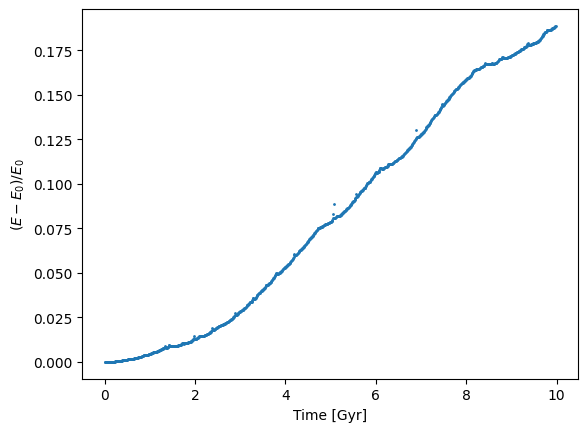

In [19]:
# check the energy conservation, remove the last snapshot:
Delta_E = ((snapshots.total_energy - snapshots.total_energy[0])/snapshots.total_energy[0])[:-1]
plt.scatter(snapshots.times[:-1], Delta_E, s=1)
plt.xlabel('Time [Gyr]')
plt.ylabel(r'$(E - E_0)/E_0$')


In [9]:
from jdgsim import utils

E_in = utils.E_tot(initial_state, mass, config, params)
E_fin = utils.E_tot(final_state, mass, config, params)  
print(f"Initial Energy: {E_in}")
print(f"Final Energy: {(E_fin-E_in)/E_in}")

NameError: name 'final_state' is not defined